# HW1

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

loading training and data sets

In [2]:
dataset_dir = "https://raw.githubusercontent.com/probml/pmtkdata/master/knnClassify3c/"
train_dataset_path = dataset_dir + "knnClassify3cTrain.txt"
test_dataset_path = dataset_dir + "knnClassify3cTest.txt"
# Train dataset
train_dataset = pd.read_csv(train_dataset_path,
 names=["x1", "x2", "class"],
 delimiter=" ")
X_train = train_dataset.iloc[:, :-1].values
y_train = train_dataset.iloc[:, -1].values
# Test dataset
test_dataset = pd.read_csv(test_dataset_path,
 names=["x1", "x2", "class"],
 delimiter=" ")
X_test = test_dataset.iloc[:, :-1].values
y_test = test_dataset.iloc[:, -1].values

Q1: plot a pairs plot and a box-whisker plot based using the training set

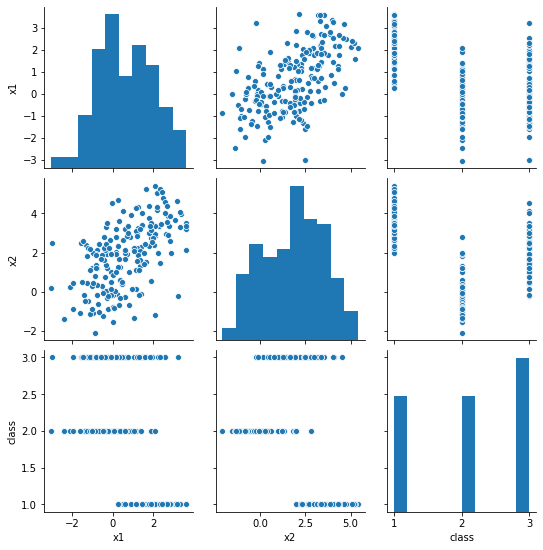

In [3]:
#pairs plot
_=sns.pairplot(train_dataset)

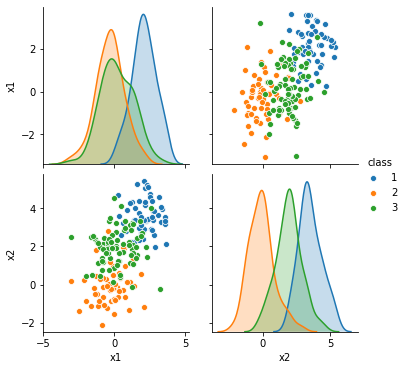

In [4]:
#change class to categorical variable
train_dataset['class'] = train_dataset['class'].astype('category',copy=False)

_=sns.pairplot(train_dataset, hue='class')

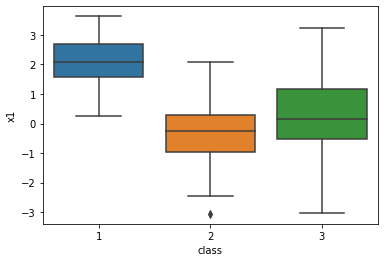

In [5]:
#  box-whisker plot
_ = sns.boxplot(x=train_dataset["class"], y=train_dataset["x1"])

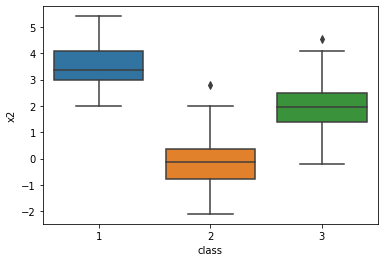

In [6]:
_ = sns.boxplot(x=train_dataset["class"], y=train_dataset["x2"])


Q2: Based on visual inspection of the pairs plot, write a function that classifies based on rules

In [7]:
def predict(x):
    """
    input:
    x: a tupple of floats of size 2 (x1, x2) represents an example
    -----
    output:
    res_class: an int representing the predicted class of x (can be 1, 2 or 3)
    """
    x1, x2 = x
    if (x1 < 0.5 and x2 < 0.5):
        res_class = 2
    elif x1 > 1 and x2 > 2:
        res_class = 1
    else:
        res_class = 3
    return res_class

Q3: Apply the rule based classifier in (2) to predict the the test set and report the misclassification rate

In [8]:
def calc_mce(pred, gold):
    """
    input:
    pred: a numpy array of predictions
    gold: a numpy array of gold (actual) classes
    -----
    output:
    The proportion if misclassifications (errors) in the pred array
    """
    counter = 0
    for p, g in zip(pred, gold):
        if p != g: #count the misclassifications
            counter += 1
    return counter / len(pred)

In [9]:
def part_3(X_test, y_test):
    """
    input:
    X_test: a numpy array of test examples
    y_test: a numpy array of labels for the examples in X_test
    -----
    The function applies the manual prediction (using the function predict) on the X-test data and reports
    the misclassification rate
    """
    pred = np.apply_along_axis(predict, 1, X_test) #get predictions
    mce = calc_mce(pred, y_test)
    print('The misclassification rate of manual classifier is: %.3f' % (mce))

In [10]:
part_3(X_test, y_test)

The misclassification rate of manual classifier is: 0.268


Q4: Apply k-NN (use this function) on the the test set and plot the miscalssification rate for k=1, k=5 and k=10 (plot misclassification rate v.s. 1/k).

For k = 1 the misclassification rate of sklearn KNN is: 0.266
For k = 5 the misclassification rate of sklearn KNN is: 0.196
For k = 10 the misclassification rate of sklearn KNN is: 0.194


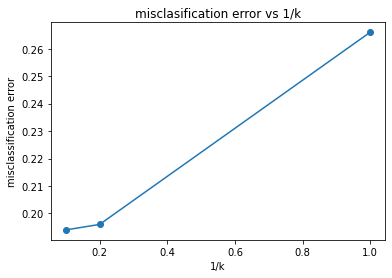

In [11]:
def sklearn_knn(X_train, y_train, X_test, y_test, k):
    """
    input:
    X_train: a numpy array of training examples
    y_train: a numpy array of labels for the examples in X_train
    X_test: a numpy array of test examples
    y_test: a numpy array of labels for the examples in X_test
    k: an int representing the number of neighbors to take into account when using the k-nn algorithm
    -----
    output:
    mce: float representing the missclassification rate achieved by the application of the k-nn algorithm
    implemented in the sklearn library with k neighbors (training is done using X_train and y_train;
    misclassification rate is then calculated by comparing the predictions on X_test with the actual labels in y_test).
    """
    neigh = KNeighborsClassifier(n_neighbors = k) #create model
    neigh.fit(X_train, y_train) #fit model using train data
    pred = neigh.predict(X_test) #get predictions for test data
    mce = calc_mce(pred, y_test) #calculate miscalssification error
    print('For k = %d the misclassification rate of sklearn KNN is: %.3f' % (k, mce))
    return mce

def part_4(X_train, y_train, X_test, y_test):
    """
    input:
    X_train: a numpy array of training examples
    y_train: a numpy array of labels for the examples in X_train
    X_test: a numpy array of test examples
    y_test: a numpy array of labels for the examples in X_test
    -----
    The function calls for sklearn_knn with different k values and then creates a plot of the 
    missclassification rate versus 1/k.
    """
    ks = [1, 5, 10] #the k values we want to check
    mces = [] #a list to hold the misclassification errors of differnet k values 
    for k in ks:
        mces.append(sklearn_knn(X_train, y_train, X_test, y_test, k)) #get miscalssification error with a specific k
    ks = [1/k for k in ks] #transform k to 1/k
    #plot graph
    plt.plot(ks, mces)
    plt.scatter(ks, mces)
    plt.xlabel('1/k')
    plt.ylabel('misclassification error')
    plt.title('misclasification error vs 1/k')
    plt.show()
    
part_4(X_train, y_train, X_test, y_test)

Q5: Apply the k-NN naïve implementation here on the test set (with k=1) and calculate the misclassification rate

In [12]:
class KNearestNeighbors:
    """
    Simple implementation of a k-NN estimator.
    """
    def __init__(self, n_neighbors: int = 1) -> None:
        self.k = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """
        Set the train dataset attributes to be used for prediction.
        """
        self.X_train = X_train
        self.y_train = y_train

    def get_neighbor_classes(self, observation: np.ndarray) -> np.ndarray:
        """
        Returns an array of the classes of the *k* nearest neighbors.
        """
        distances = np.sqrt(np.sum((self.X_train - observation) ** 2, axis = 1))

        # Create an array of training set indices ordered by their
        # distance from the current observation
        indices = np.argsort(distances, axis = 0)

        selected_indices = indices[:self.k]
        return self.y_train[selected_indices], distances[selected_indices]

    def estimate_class(self, observation: np.ndarray) -> int:
        """
        Estimates to which class a given row (*observation*) belongs.
        """
        neighbor_classes, _ = self.get_neighbor_classes(observation)
        classes, counts = np.unique(neighbor_classes, return_counts = True)
        return classes[np.argmax(counts)]

    def estimate_class_weighted(self, observation: np.ndarray) -> int:
        """
        Estimates to which class a given row (*observation*) belongs with the weighted prediction.
        """
        neighbor_classes, distances = self.get_neighbor_classes(observation) #get k nearest neighbors and distances
        weights =  np.where(distances == 0, 1, 1 / (distances ** 2)) #get distances from weights
        classes = np.unique(neighbor_classes) #get possible classes
        best_c, best_w = 0, 0
        for c in np.nditer(classes): # for every class
            w = np.sum(weights[np.nonzero(neighbor_classes == c)]) #calculates the sum of weights (i.e. sum(wi*I(yi, c)))
            best_w, best_c = (w, c) if w > best_w else (best_w, best_c) #update best class and its weight
        return best_c #returns best class (i.e. with the maximal sum(wi*I(yi, c))

    def predict(self, X: np.ndarray):
        """
        Apply k-NN estimation for each row in a given dataset.
        """
        return np.apply_along_axis(self.estimate_class, 1, X)

    def predict_weighted(self, X: np.ndarray):
        """
        Apply k-NN estimation for each row in a given dataset with weighted predictions.
        """
        return np.apply_along_axis(self.estimate_class_weighted, 1, X)


In [13]:
kinds = ['naive', 'weighted'] #the possible weighting methods, relevant for Q7

def part_5(X_train, y_train, X_test, y_test, k, kind = 'naive'):
    """
    input:
    X_train: a numpy array of training examples
    y_train: a numpy array of labels for the examples in X_train
    X_test: a numpy array of test examples
    y_test: a numpy array of labels for the examples in X_test
    k: an int representing the number of neighbors to take into account when using the k-nn algorithm
    kind: string (default = 'naive') represents the weighting method
    -----
    output:
    mce: float representing the missclassification rate achieved by the application of the naive implementation
    of the k-nn algorithm with k neighbors (training is done using X_train and y_train;
    misclassification rate is then calculated by comparing the predictions on X_test with the actual labels in y_test).
    """
    assert kind in kinds
    neigh = KNearestNeighbors(n_neighbors = k) #create model
    neigh.fit(X_train, y_train) #fir model using training data
    #get predictions for test data
    if kind == 'naive':
        pred = neigh.predict(X_test)
    else: #i.e. weighted
        pred = neigh.predict_weighted(X_test)
    mce = calc_mce(pred, y_test) #calculate misclassification error
    print('For k = %d the misclassification rate for %s KNN is: %.3f' % (k, kind, mce))
    return mce

part_5(X_train, y_train, X_test, y_test, 1)

For k = 1 the misclassification rate for naive KNN is: 0.266


0.266

Q6: Modify the code in (5) so that it implements a distance weighted k-NN.

This part was done under the KNearestNeighbors class, see the functions predict_wighted and estimate_class_weighted.

Q7: Repeat (4) by using the modified code from (6).

For k = 1 the misclassification rate for weighted KNN is: 0.266
For k = 5 the misclassification rate for weighted KNN is: 0.240
For k = 10 the misclassification rate for weighted KNN is: 0.230


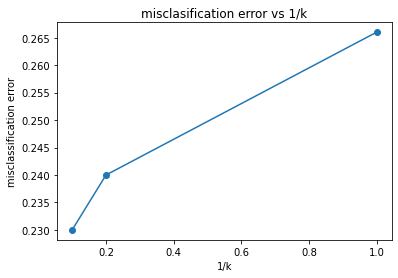

In [14]:
def part_7(X_train, y_train, X_test, y_test):
    """
    input:
    X_train: a numpy array of training examples
    y_train: a numpy array of labels for the examples in X_train
    X_test: a numpy array of test examples
    y_test: a numpy array of labels for the examples in X_test
    -----
    The function calls for part_5 with different k values and with kind = 'weighted',
    then creates a plot of the missclassification rate versus 1/k.
    """
    ks = [1, 5, 10] #the k values we want to check
    mces = [] #a list to hold the misclassification errors of differnet k values
    for k in ks:
        mces.append(part_5(X_train, y_train, X_test, y_test, k, kind = 'weighted')) #get misclassification error with a specific k
    ks = [1/k for k in ks] #transform k to 1/k
    #plot graph
    plt.plot(ks, mces)
    plt.scatter(ks, mces)
    plt.xlabel('1/k')
    plt.ylabel('misclassification error')
    plt.title('misclasification error vs 1/k')
    plt.show()
    
part_7(X_train, y_train, X_test, y_test)

Q8: What would you do if the features are measured by different units?

We will scale the features (for example to the 0 - 1 range by using minmax scaling, or standardizing the different features). In the case in which only the units differ it is also possible to transform them accordingly (e.g. to tranform from Celsius to Fahrenheit we would apply 1.8*c + 32 to get f) though if other charectaristics differ it might not be good enough. 